In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import warnings
from pathlib import Path
from typing import List
import pandas as pd
from ams.models.xgb_reg import get_weights
from ams.pipes.p_make_prediction.DayPredictionInfo import DayPredictionInfo
from ams.pipes.p_make_prediction.mp_process import get_stocks_merged, get_split_dfs, split_train_test
from ams.pipes.p_stock_merge.sm_process import get_stock_merge_trainer_params
from ams.twitter.TrainAndPredictionParams import PredictionMode
from ams.twitter.twitter_ml_utils import transform_to_numpy

from ams.config import logger_factory, constants
logger = logger_factory.create(__name__)

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import xgboost as xgb

def get_trainer(df_train: pd.DataFrame,
                df_test: pd.DataFrame):

    require_balance: bool = False
    label_col = "stock_val_change"
    narrow_cols = list(df_train.columns)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
        X_train, y_train, standard_scaler = transform_to_numpy(df=df_train,
                                                               narrow_cols=narrow_cols,
                                                               label_col=label_col,
                                                               require_balance=require_balance)

    if X_train is None or X_train.shape[0] == 0 or y_train is None:
        raise Exception("Not enough training data.")
        
    # grid_search(X_train=X_train, y_train=y_train)
    xgb_reg = xgb.XGBRegressor(seed=42, max_depth=8, tree_method='gpu_hist', gpu_id=0, verbose_eval=100)

    return X_train, y_train, xgb_reg

In [45]:
twitter_root_path = constants.TWITTER_OUTPUT_RAW_PATH
stock_merge_drop_path = Path(twitter_root_path, "stock_merge_drop", "main")

df = get_stocks_merged(stock_merge_drop_path=stock_merge_drop_path)
df = df.dropna(subset=["stock_val_change"])
df = df.drop(columns=["closeadj", "user_time_zone"])

def remove_ticker_cols(df: pd.DataFrame):
    cols = list(df.columns)
    new_cols = []
    for c in cols:
        if not c.startswith("f22_ticker"):
            new_cols.append(c)
    df = df[sorted(new_cols)]
    
    return df


In [46]:
tapp = get_stock_merge_trainer_params(stock_merge_drop_path=stock_merge_drop_path)
tapp.prediction_mode = PredictionMode.RealMoneyStockRecommender

purchase_date_str = "2021-03-10"
split_dfs, tweet_date_str = get_split_dfs(df, purchase_date_str=purchase_date_str, tapp=tapp)

df_s1 = split_dfs.dfs[0]

# df_s1 = df_s1.drop(columns=["closeadj"]).copy()

In [47]:
df_train, df_test = split_train_test(df=df_s1,
                                     tweet_date_str=tweet_date_str)

X_train, y_train, xgb_reg = get_trainer(df_train=df_train, df_test=df_test)

model = xgb_reg.fit(X_train, y_train, sample_weight=get_weights(df=df_train))

18:54:10 - ams.pipes.p_make_prediction.mp_process:29 - INFO - Splitting on tweet date 2021-03-09
18:54:11 - ams.pipes.p_make_prediction.mp_process:37 - INFO - Test data size: 1250
18:54:11 - ams.pipes.p_make_prediction.mp_process:38 - INFO - Train data size: 44434
18:54:11 - ams.pipes.p_make_prediction.mp_process:39 - INFO - Oldest date of train data (future_date): 2021-03-12
18:54:11 - ams.pipes.p_make_prediction.mp_process:40 - INFO - Oldest date of test data (future_date): 2021-03-15
[18:54:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [56]:
from matplotlib import pyplot as plt
from ams.services import twitter_service

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

narrow_cols = list(df_train.columns)
narrow_cols = [c.replace("[", "") for c in narrow_cols]
narrow_cols = [c.replace("]", "") for c in narrow_cols]
narrow_cols = [c.replace("<", "") for c in narrow_cols]
train_cols = twitter_service.get_feature_columns(narrow_cols)
df_retrain = pd.DataFrame(X_train, columns=train_cols)

# print(df_s1.shape[0])
# df_nan = df_s1.isnull().sum(axis = 0).to_frame().reset_index()
# type(df_nan)
# df_nan.columns = ["field", "count"]
# df_nan[df_nan["count"] > 0].head(100)


In [58]:
import matplotlib.pyplot as plt
import numpy as np

# print(list(xgb_reg.feature_importances_))
# plt.barh(list(df_retrain.columns), xgb_reg.feature_importances_)

rows = []
for ndx, fi in enumerate(list(xgb_reg.feature_importances_)):
    r = {"feature_importance": fi, "feature_name": train_cols[ndx]}
    rows.append(r)

df_fi = pd.DataFrame(rows, columns=["feature_importance", "feature_name"])
df_fi.loc[:, "feature_name"] = df_retrain.columns
df_fi.sort_values(by=["feature_importance"], inplace=True)

unimport_feat = df_fi[df_fi["feature_importance"] == 0]["feature_name"].unique()
# print(list(unimport_feat))

df_fi = df_fi[df_fi["feature_importance"] > 0].copy()

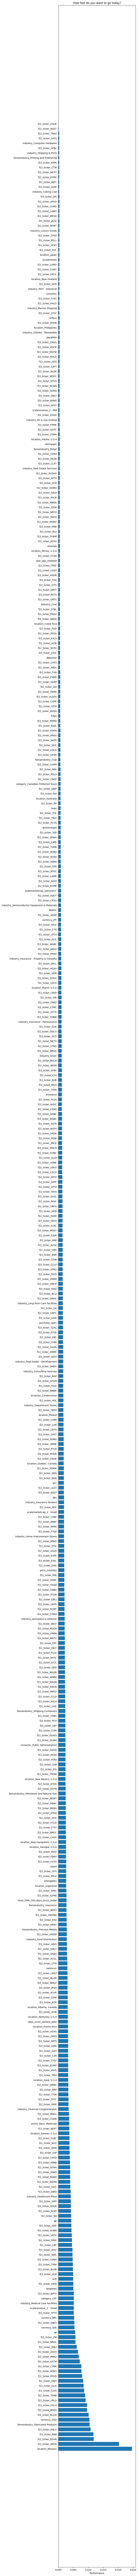

In [60]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(6, 200))

# Example data
feat_name = df_fi["feature_name"]
y_pos = np.arange(len(feat_name))
feature_importance = df_fi["feature_importance"] # 3 + 10 * np.random.rand(len(people))

ax.barh(y_pos, feature_importance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feat_name)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('How fast do you want to go today?')

plt.show()

In [26]:
# print(list(df_retrain.columns))

# import shap

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(df_retrain)
# shap.summary_plot(shap_values, df_retrain, plot_type="bar")

In [8]:
list(df_train.columns)[0]

'3_down_in_row'